## Machine Learning and Statistics Project 2020
***


The aim of this project is to create a web service that uses machine learning to make predictions based on the data set 'powerproduction'. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. Then, to develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.

<br>



<br>

## Introduction

***

There are a number of steps involved in creating an accurate predictive model as described in the project brief. This project follows these steps, providing explanations for the choice of model used through analysis of the *powerproduction* data set. With this in mind, it is divided into the following sections:

* Preliminary Analysis
* Function Approximation (Regression vs Classification)
* Regression with `scikit-learn`
* Regression with `keras`
* Model evaluation

<br>



## 1. Preliminary Analysis

***

First, I import the modules needed and choose a style for visualisation throughout the project:

* `numpy` is a python library which allows us to work with arrays, more suited to data analysis than traditional python `lists` [1] 
* `pandas` is suited to working with data sets and provides the DataFrame structure to make this more effective and efficient [2]. 
* `matplotlib.pyplot` is used for visualisation. It is a graph plotting library on which many visualisation packages are built in python. The `pyplot` submodule contains most of matplotlib's utilities [3]
* With the `scikit-learn` library, we have access to numerous machine learning algorithms [4]. In this project it is used to generate predictive models and also to evaluate those models. 
* `tensorflow` is a machine learning platform with a focus on working with and training neural networks [5]. `keras` is an API built on tensorflow, providing an interface for working with neural networks [6].

In [1]:
# Working with arrays
import numpy as np

# Working with dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Linear regression algorithm
from sklearn.linear_model import LinearRegression

# Working with more complex variable relationships
from sklearn.preprocessing import PolynomialFeatures

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Working with neural networks
import tensorflow.keras as kr

In [2]:
# Plot style
plt.style.use('ggplot')

# Plot size
plt.rcParams['figure.figsize'] = [11, 6]

Next, I read in the dataset using `pandas.read_csv` which stores the data in a pandas dataframe. I assign this to `pp` and output the first 10 rows. With `pandas.describe` we get a statistical summary of the data set:

In [3]:
# Read in data set
pp = pd.read_csv('powerproduction.csv')

# Output first 10 rows
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [4]:
# Output summary statistics of data set
pp.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The data set contains two continuous variables. To get an overview of the relationship between them, we can plot them using a scatterplot. Visualising this relationship is a useful first step in understanding what predictive model might be suitable. It can also offer other insights, such as the presence of outliers: 

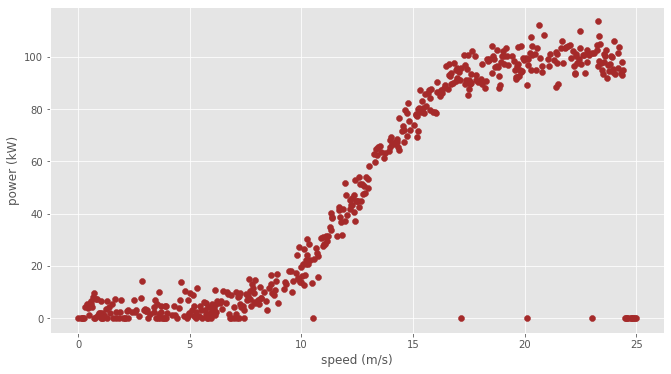

In [5]:
# Plot data on a scatter plot
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.scatter(pp['speed'], pp['power'], color='brown', marker='o')

#### Wind Turbine Power Curve
This plot produces a visualisation of the typical wind turbine power curve. The *cut-in* wind speed is at ~7m/s, below which the turbine is producing hardly any power. Between wind speeds of ~7 and ~17m/s the power ramps up to what is known as the *rated power capacity*. From approximate speeds of ~17m/s the power generated remains constant, right up to ~25m/s, or the *cut-out* wind speed. While there is much potential power in the wind speed above the cut-out speed, the cost of making the turbine capable of producing power under these conditions outweights the benefits of more power being generated [7]. <br>

#### Outliers
What is also notable from the plot is the presence of seeming outliers in the data. There are a number of observations where no power (0kW) is being generated despite sufficiently high wind speeds. This is something which will be examined in greater detail below.

#### What Predictive Model?
Through visualisation we can get a preliminary indication of what model might best be suited when predicting power output from wind speed. Initial inclinations would suggest that this is a *regression* problem. Given that there are only two variables in the data set, simple linear regression may be an appropriate model although fitting a straight line to the data may not yield the most accurate predictions. It might be more suitable to fit a curve. The variables are clearly *positively* correlated between the *cut-in* speed and the *rated power capacity*. 

##### end section 1

<br>



## 2. Function Approximation: Classification vs Regression

***

*Function approximation* is the term used to describe the problem of approximating a mapping function from input variables to output variables. Generally speaking, function approximation problems can be divided into *classification* and *regression* tasks [8]. Deciding between which of these is most appropriate for the current project is the next step.

#### Classification vs Regression
"Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to *discrete* output variables (y)" [9], while the output variables for regression models are *continuous* numeric variables. The aim of the current project is to predict power output from wind speed. As noted above, this is a continuous numeric variable which tells us that regression is an appropriate model/function for this task.

#### Regression
Regression is a statistical method which describes the relationship between a dependent variable and one or more independent variables [10]. Additionally, it is associated with fitting a line (or curve) to the data by plotting the line over the data points to get the best fit [11]. Taking a look data as plotted on a scatter plot, it is clear that we could fit a line (or curve) in order to accurately predict the dependent variable.



##### end section 2

<br>



## 3. Regression with `scikit-learn`

***

`scikit-learn` is a machine learning library for the python programming language. It provides a range of machine learning algorithms and is used widely for the purposes of predictive modelling [12]. In the current project, `scikit-learn`'s `LinearRegression` model will be applied to the *powerproduction* data set. Additionally, the package provides a number of tools which will be used to prepare the data and evaluate the models created below.

### 3.1 Data preparation

***

Before building the first model, it is necessary to prepare the data to maximise the ultimate accuracy of the predictions. Firstly, I use a function to dectect any outliers which may impact the performance of the models. Second, I split the data set into subsets using the *train-test split* procedure.


#### 3.1.1 Outliers

When training a predictive model, it is important to remove any outliers so that the data we train the model on most accurately represents the situation at hand. The removal of outliers must be handled sensitively and cautiously so as not to misrepresent the data, and because every data set is different, there is often a lack of clearly defined rules around how to deal with them [13].

Prior to removing any identified outliers, let us first see how a simple linear regression model performs with the orignial data set. The data is split into training and testing data. This procedure is explored and explained in greater detail below:

In [64]:
# Using original (pp) data set to train model 
speed_df_pp = pp.drop('power',axis='columns')
power_df_pp = pp.drop('speed',axis='columns')

# Train test split
A_Train_pp, A_Test_pp, B_Train_pp, B_Test_pp = train_test_split(speed_df_pp, power_df_pp, test_size = 0.5, random_state=1)

# Create model
reg_pp = LinearRegression()

# Fit model
reg_pp.fit(A_Train_pp, B_Train_pp)

# Calculate R-squared value
score_pp = reg_pp.score(A_Train_pp, B_Train_pp)

# Print score
print(score_pp)

0.7380879260677631


Training the model using the full data set yields a score of ~0.74. This represents the R-Squared value of the model. 

<br>

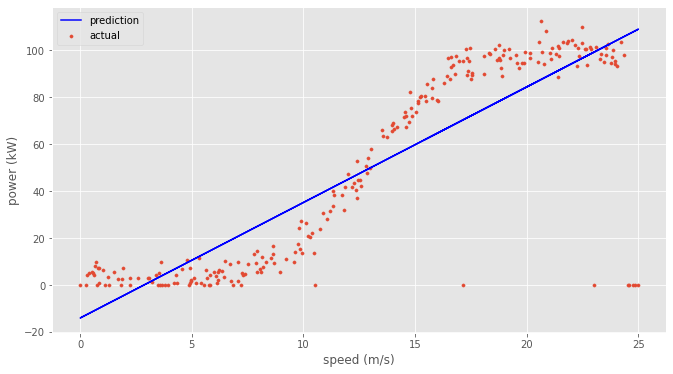

In [69]:
# Use model to make predictions
pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

#### 3.1.2 Outlier detection and removal

As we saw above, visualisation can give us a strong indication that some of the observations may need to be removed. However, statistical methods can also be used to detect extreme or unlikely values in a data set. 

##### Mahalonibis Distance

In researching outlier detection, much of the online resources appear to deal with *univariate* outliers [14], [15]. Additionally, detection tools available as part of the `scikit-learn` library e.g. `LocalOutlierFactor`, (which uses the nearest neighbours algorithm to detect outliers in a sample) were not suited to the current project. For *multivariate* outliers, a common statistical method of dection is the *Mahalonibis Distance* measure, which is "... widely used distance metric for the detection of multivariate outliers..." [16]. Indeed it has been applied to wind turbine curve modeling by a number of studies (e.g. Pei and Li, 2019) [17]. 

The code for the function below was found on an informative blog post [18] and applies Mahalonibis Distance to the data set to detect outliers. This function returns a list of index values for the rows containing outliers as detected by the method. I locate these rows using the `pandas.loc` method and remove them from the data set:

In [65]:
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

# Set variable df to equal pp data set
df = pp

#Robust Mahalonibis Distance
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=df)

In [66]:
# Find rows containing outlier indices
pp_outliers = pp.loc[ outliers_mahal_rob , : ]

# Output dataframe of outliers
pp_outliers

,speed,power
340,17.167,0.0
404,20.095,0.0
456,22.998,0.0
490,24.499,0.0
491,24.525,0.0
492,24.575,0.0
493,24.650,0.0
494,24.750,0.0
495,24.775,0.0
496,24.850,0.0


Above is the data frame containing the outlier observations. All the outliers detected have a power value of 0kW. This is what was observed in the scatterplot. Below, I remove them from the data set, creating an updated data set `pp_clean` in the process:

In [67]:
# Remove outliers from data set
pp_clean = pp.drop(outliers_mahal_rob)

In [68]:
pp_clean.describe()

,speed,power
count,487.000000,487.000000
mean,12.294641,49.296287
std,7.077215,41.409933
min,0.000000,0.000000
25%,6.143500,5.769000
50%,12.337000,44.745000
75%,18.380500,93.733500
max,24.399000,113.556000


<br>




#### 3.1.3 Train-test split

The goal of this project is to accurately predict wind turbine power output from wind speed values. Indeed, it is the aim of any predictive model to maximise the accuracy of model output. In machine learning, *evaluation* and *validation* are key aspects in measuring how accurate a model is in this regard [19]. To ensure that the potential for bias is minimized when evaluating model performance, it is common practice in supervised machine learning to apply the *train-test split* procedure. This involves training a model by splitting the data into subsets. The *train* subset is used to train the model while the *test* subset is held back in order to test the model's accuracy. Given that we already know the output values for the test subset, we can make informed comparisons between the predicted observed values. (It is worth pointing out that it may not always be appropriate as a technique to increase accuracy of prediction e.g. if the data set is too small [20].) 



<br>

First, the `pp_clean` data set is split by column into two separate subsets, one containing each variable. :

In [10]:
# Create a new dataset containing only values from the speed column
speed_df = pp_clean.drop('power',axis='columns')

#  Print first 10 rows
speed_df.head(10)

,speed
0,0.000
1,0.125
2,0.150
3,0.225
4,0.275
5,0.325
6,0.400
7,0.450
8,0.501
9,0.526


In [11]:
# Create a new dataset containing only values from the power column
power_df = pp_clean.drop('speed',axis='columns')

# Print first 10 rows
power_df.head(10)

,power
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,4.331
6,5.186
7,3.826
8,1.048
9,5.553


<br>

Next, I pass the speed_df and power_df dataframe subsets to `scikit-learn`'s `train_test_split` method and set the parameter *test_size* to 0.5. The test size indicates the size of the train and test sets. Common split percentages include

* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50% [21]

The values for the train and test subsets are randomly selected, so I set *random_state* to 1. This reproduces the same division of the data each time the program is run. Setting the seed also allows for more representative model comparison as well as parameter comparison when assessing the performance of different models and functions.

In [12]:
# Call train_test_split method on dataframes
A_Train, A_Test, B_Train, B_Test = train_test_split(speed_df, power_df, test_size = 0.5, random_state=1)


<br>

### 3.2 Simple linear regression

***

Simple linear regression is "... the simplest case of linear regression with a single independent variable" [22]. Its equation is often expressed as <br> $$ y = \Theta_0 + \Theta_1x $$ <br> The *powerproduction* data set contains one independent variable (speed) and one dependent variable (power).  function imported from Python's Scikit-learn library to produce a model. Simple linear regression can be applied when the data set contains only two variables - a dependent and independent variable. This is a condition which is filled by the 'powerproduction' data set.


#### 3.2.1 Fitting the model

I then create an instance of the `LinearRegression()` class and call the `fit` method, passing the training data as arguments. This will create a simple linear regression model:

In [13]:
# Create an instance of the LinearRegression class
reg = LinearRegression()

# Fit our data to the model
#reg.fit(speed_df, power_df)
reg.fit(A_Train, B_Train)

LinearRegression()

#### Check performance

With the training data now fit to the model, the next step is to use the `score` method to see how well the it is performing. This method calculates the the R-squared value (or coefficient of determination [23]). The R-squared value is a 'goodness-of-fit' measure which can give us an indication as to the accuracy of our regression model. The best possible score is 1.0, while a score of 0 or a negative value generally represents a worse-fitting line. The R-squared value "indicates the percentage of the variance in the dependent variable that the independent variables explain collectively." [24] It is worth noting that a high R-squared does not necessarily always indicate the best fit [25].


In [14]:
# Calculate R-squared value
score = reg.score(A_Train, B_Train)

# Print value
print(score)

0.9016673587884961


#### Prediction

Finally, I call the `predict` method on the test data for wind output prediction before plotting this to visualise how well the line fits the data:

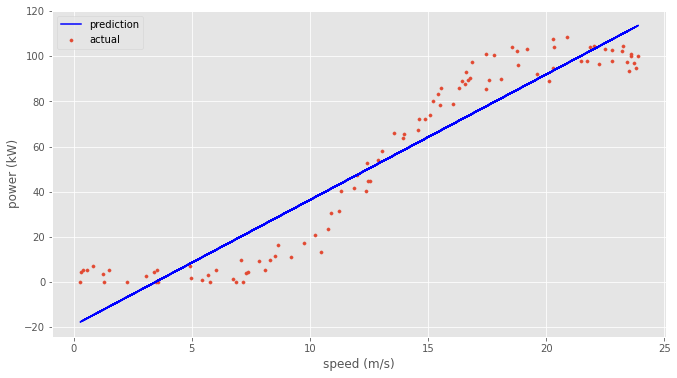

In [15]:
# Use model to make predictions
prediction = reg.predict(A_Test)

# Plot fitted line against data for visualisation
plt.scatter(A_Test, B_Test, label='actual', s=10)
plt.plot(A_Test, prediction, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

We can see clearly that a straight line does not fit the data very well. For certain predictive models, an R-squared value of ~0.90 might be considered a satisfactory score. However for the current project, it makes sense to attempt to fit a curve to the data to maximise accuracy of predicted output. The following section applies polynomial regression to the data.

#### Outlier vs no outlier
Before moving to the next section, let us briefly create a model with the original data set (prior to outlier removal) in order to demonstrate the impact of dropping outliers from the data set:

When the model is trained using the original data set, we can see that there is a significant drop in the score. (~0.74 vs ~0.90). This demonstrates the importance of outlier removal, if appropriate.

<br>

### 3.3 Polynomial regression

***

Visualising the plot above, we can see that the straight line does not follow the curve of the data. This is an example of *under-fitting* [26]. In order to overcome this problem, the complexity of the model needs to be increased. With polynomial regression, we can generate a curve that better captures the data. It involves generating a higher order equation by adding powers to convert features into their higher order terms [27]. The equation for polynomial regression is commonly expressed as: $$ y = \Theta_0 + \Theta_1x + \Theta_2x^2 + \Theta_3x^3 + ... + \Theta_nx^n $$ <br>

`scikit-learn` provides the `PolynomialFeatures` class which enables us to transform features to their higher order terms by setting the degree parameter to the desired power. Then, this model can be trained using `LinearRegression` just as above. The code for this is based on an informative towardsdatascience.com blog post [28].

<br>



First, the training data is converted to numpy arrays. This makes it easier to sort and plot below. Then, an instance of the `PolynomialFeatures` class is created, generating polynomial degrees to the 9th degree. This is the degree value that yields the highest R-Squared score. The `fit_transform` method applies polynomial transformation of degree 9. The transformed feature (wind speed) is then fitted to the model and predictions are made based on the test data. 

In [17]:
pp_clean2 = pp_clean.drop([208])
A_Train2, A_Test2, B_Train2, B_Test2 = train_test_split(pp_clean2.speed, pp_clean2.power, test_size = 0.2, random_state=1)

In [18]:
# Convert train and test subsets to numpy arrays
poly_speed_train = A_Train2.to_numpy().reshape(-1, 1)
poly_power_train = B_Train2.to_numpy().reshape(-1, 1)
poly_speed_test  = A_Test2.to_numpy().reshape(-1, 1)
poly_power_test = B_Test2.to_numpy().reshape(-1, 1)

# Create PolynomialFeatures class instance with degree=9
poly_features = PolynomialFeatures(degree=9)

# Apply polynomial transformation of degree 9
train_speed = poly_features.fit_transform(poly_speed_train)

# Create instance of LinearRegression class
poly_model = LinearRegression()

# Train the model with training data
poly_model.fit(train_speed, poly_power_train)

# Use the model to predict power output of test data
y_test_predict = poly_model.predict(poly_features.fit_transform(poly_speed_test))

In [19]:
# Calculate mean squared error 
mse_test = mean_squared_error(poly_power_test, y_test_predict)

# Calculate coeeficient of determination
r2_test = r2_score(poly_power_test, y_test_predict)

# Output reults to the screen
mse_test, r2_test

(18.30473912370965, 0.9892671550780056)

With an R-Squared value of ~0.99 we can see that polynomial regression performs significantly better than the simple linear regression above.

<br>

When plotted on a graph, it is clear that the curve captures the data much more closely:

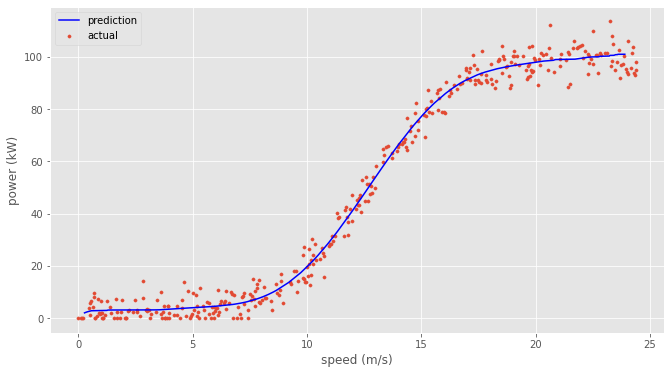

In [20]:
# Plot on scatterplot
plt.scatter(poly_speed_train, poly_power_train, label='actual', s=10)

sorted_poly_speed_test = np.sort(poly_speed_test, 0)
sorted_y_test_predict = np.sort(y_test_predict, 0)


# # Plot line based on model predictions
# plt.plot(sorted_poly_x, sorted_y_test_predict, label='prediction', color='b')
plt.plot(sorted_poly_speed_test, sorted_y_test_predict, label='prediction', color='b')

# Labels
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

In [21]:
B_Train.loc[B_Train['power'] == 0]

,power
208,0.0
39,0.0
89,0.0
73,0.0
111,0.0
16,0.0
0,0.0
105,0.0
70,0.0
42,0.0


In [22]:
B_Test.loc[B_Test['power'] == 0]

,power
67,0.0
31,0.0
4,0.0
47,0.0
65,0.0
135,0.0
110,0.0


In [23]:
pp_clean3 = pp_clean[pp_clean['power'] != 0] 
pp_clean3.head(10)

,speed,power
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553
10,0.551,6.498
11,0.576,5.241
12,0.626,4.220
13,0.676,7.974
14,0.701,9.746


In [24]:
A_Test.shape

(98, 1)

<br>

Next, I call the `intercept_` method to determine where the line intercepts the y-axis. And below that I use call `coef_` to get the slope of the line. This gives us all the values for formula for the best-fitting line: $$y = mx + b$$ where m is the slope, b is the y-interept and x is the independent variable [3].

[3] dummies.com; How to calculate a regression line; https://www.dummies.com/education/math/statistics/how-to-calculate-a-regression-line/ <br>

In [25]:
# Call the intercept_ method to determine where the line intercepts the y-axis
reg.intercept_

array([-19.1807797])

In [26]:
# Call the coef_ method to calculate the slope of the line
reg.coef_

array([[5.55688005]])

In [27]:
# Set calculated values
m = 4.91759567
x = 9.746
b = -13.899902630519641

y = m*x + b
print(y)

34.02698476930036


As expected, we get the same result for y when we input these values into the formula (above)
<br>



In [28]:
# Calculate R-squared value
reg.score(speed_df, power_df)

0.9009529405175993

<br>


***

## Neural network - Regression

***

In [29]:
#pp = pp[pp.power != 0]
#pp.describe()

In [30]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

In [31]:
model = create_model()

In [32]:


msk = np.random.rand(len(pp_clean2)) < 0.5
train = pp_clean2[msk]

test = pp_clean2[~msk]

In [33]:
model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

Epoch 1/500
25/25 [==============================] - 2s 2ms/step - loss: 3353.7946
Epoch 2/500
25/25 [==============================] - 0s 3ms/step - loss: 2147.9125
Epoch 3/500
25/25 [==============================] - 0s 3ms/step - loss: 875.5974
Epoch 4/500
25/25 [==============================] - 0s 3ms/step - loss: 273.3538
Epoch 5/500
25/25 [==============================] - 0s 3ms/step - loss: 253.8054
Epoch 6/500
25/25 [==============================] - 0s 3ms/step - loss: 253.3354
Epoch 7/500
25/25 [==============================] - 0s 3ms/step - loss: 290.1692
Epoch 8/500
25/25 [==============================] - 0s 3ms/step - loss: 258.0103
Epoch 9/500
25/25 [==============================] - 0s 3ms/step - loss: 230.0696
Epoch 10/500
25/25 [==============================] - 0s 3ms/step - loss: 216.0092
Epoch 11/500
25/25 [==============================] - 0s 3ms/step - loss: 235.0294
Epoch 12/500
25/25 [==============================] - 0s 3ms/step - loss: 224.0099
Epoch 13/50

25/25 [==============================] - 0s 2ms/step - loss: 68.4317
Epoch 101/500
25/25 [==============================] - 0s 2ms/step - loss: 61.9546
Epoch 102/500
25/25 [==============================] - 0s 2ms/step - loss: 83.3068
Epoch 103/500
25/25 [==============================] - 0s 3ms/step - loss: 67.6530
Epoch 104/500
25/25 [==============================] - 0s 2ms/step - loss: 62.3527
Epoch 105/500
25/25 [==============================] - 0s 2ms/step - loss: 70.3898
Epoch 106/500
25/25 [==============================] - 0s 2ms/step - loss: 68.0193
Epoch 107/500
25/25 [==============================] - 0s 2ms/step - loss: 67.1739
Epoch 108/500
25/25 [==============================] - 0s 2ms/step - loss: 56.3388
Epoch 109/500
25/25 [==============================] - 0s 2ms/step - loss: 61.2366
Epoch 110/500
25/25 [==============================] - 0s 2ms/step - loss: 68.8330
Epoch 111/500
25/25 [==============================] - 0s 3ms/step - loss: 66.8049
Epoch 112/500
25/2

25/25 [==============================] - 0s 2ms/step - loss: 44.8279
Epoch 199/500
25/25 [==============================] - 0s 2ms/step - loss: 44.5217
Epoch 200/500
25/25 [==============================] - 0s 2ms/step - loss: 40.7655
Epoch 201/500
25/25 [==============================] - 0s 2ms/step - loss: 39.3466
Epoch 202/500
25/25 [==============================] - 0s 2ms/step - loss: 43.5714
Epoch 203/500
25/25 [==============================] - 0s 3ms/step - loss: 46.5667
Epoch 204/500
25/25 [==============================] - 0s 2ms/step - loss: 38.0410
Epoch 205/500
25/25 [==============================] - 0s 3ms/step - loss: 42.5154
Epoch 206/500
25/25 [==============================] - 0s 2ms/step - loss: 42.4858
Epoch 207/500
25/25 [==============================] - 0s 3ms/step - loss: 35.2148
Epoch 208/500
25/25 [==============================] - 0s 3ms/step - loss: 40.3567
Epoch 209/500
25/25 [==============================] - 0s 3ms/step - loss: 32.6422
Epoch 210/500
25/2

25/25 [==============================] - 0s 3ms/step - loss: 18.4886
Epoch 297/500
25/25 [==============================] - 0s 2ms/step - loss: 21.3510
Epoch 298/500
25/25 [==============================] - 0s 2ms/step - loss: 19.2483
Epoch 299/500
25/25 [==============================] - 0s 2ms/step - loss: 22.4774
Epoch 300/500
25/25 [==============================] - 0s 2ms/step - loss: 20.6449
Epoch 301/500
25/25 [==============================] - 0s 2ms/step - loss: 21.5447
Epoch 302/500
25/25 [==============================] - 0s 2ms/step - loss: 25.9857
Epoch 303/500
25/25 [==============================] - 0s 3ms/step - loss: 24.9090
Epoch 304/500
25/25 [==============================] - 0s 3ms/step - loss: 24.8959
Epoch 305/500
25/25 [==============================] - 0s 3ms/step - loss: 19.4917
Epoch 306/500
25/25 [==============================] - 0s 2ms/step - loss: 20.3269
Epoch 307/500
25/25 [==============================] - 0s 3ms/step - loss: 22.2381
Epoch 308/500
25/2

25/25 [==============================] - 0s 2ms/step - loss: 20.6917
Epoch 395/500
25/25 [==============================] - 0s 3ms/step - loss: 19.5029
Epoch 396/500
25/25 [==============================] - 0s 2ms/step - loss: 17.9742
Epoch 397/500
25/25 [==============================] - 0s 2ms/step - loss: 21.3064
Epoch 398/500
25/25 [==============================] - 0s 2ms/step - loss: 20.9766
Epoch 399/500
25/25 [==============================] - ETA: 0s - loss: 16.50 - 0s 2ms/step - loss: 18.8592
Epoch 400/500
25/25 [==============================] - 0s 3ms/step - loss: 18.9095
Epoch 401/500
25/25 [==============================] - 0s 3ms/step - loss: 17.4654
Epoch 402/500
25/25 [==============================] - 0s 3ms/step - loss: 21.1266
Epoch 403/500
25/25 [==============================] - 0s 3ms/step - loss: 16.1939
Epoch 404/500
25/25 [==============================] - 0s 2ms/step - loss: 19.5809
Epoch 405/500
25/25 [==============================] - 0s 3ms/step - loss: 17

25/25 [==============================] - 0s 3ms/step - loss: 21.3234
Epoch 493/500
25/25 [==============================] - 0s 3ms/step - loss: 17.4977
Epoch 494/500
25/25 [==============================] - 0s 3ms/step - loss: 14.7511
Epoch 495/500
25/25 [==============================] - 0s 2ms/step - loss: 16.5784
Epoch 496/500
25/25 [==============================] - 0s 3ms/step - loss: 18.4261
Epoch 497/500
25/25 [==============================] - 0s 2ms/step - loss: 16.9899
Epoch 498/500
25/25 [==============================] - 0s 2ms/step - loss: 16.9193
Epoch 499/500
25/25 [==============================] - 0s 3ms/step - loss: 18.2219
Epoch 500/500
25/25 [==============================] - 0s 2ms/step - loss: 20.0554


In [34]:
shapes = model.predict(test['speed'])

In [35]:
shapes.shape

(240, 1)

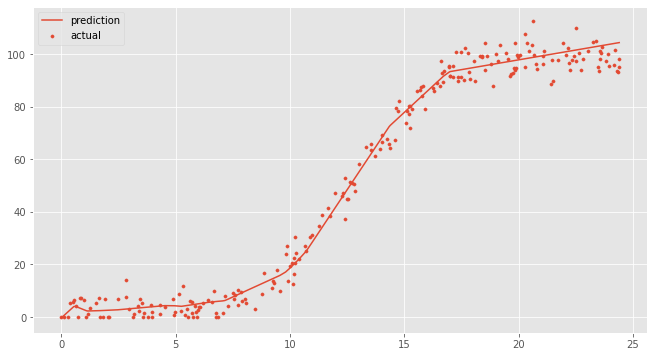

In [36]:
plt.scatter(test['speed'], test['power'], label='actual', s=10)
plt.plot(test['speed'], model.predict(test['speed']), label='prediction')
plt.legend()

In [37]:
model.fit(A_Train, B_Train, epochs=500, batch_size=10)

Epoch 1/500
39/39 [==============================] - 1s 4ms/step - loss: 20.6134
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 20.2589
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 20.5490
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 20.1839
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 19.9399
Epoch 6/500
39/39 [==============================] - 0s 5ms/step - loss: 19.4112
Epoch 7/500
39/39 [==============================] - 0s 4ms/step - loss: 19.9584
Epoch 8/500
39/39 [==============================] - 0s 4ms/step - loss: 20.7943
Epoch 9/500
39/39 [==============================] - 0s 5ms/step - loss: 19.2726
Epoch 10/500
39/39 [==============================] - 0s 4ms/step - loss: 19.1363
Epoch 11/500
39/39 [==============================] - 0s 4ms/step - loss: 19.6814
Epoch 12/500
39/39 [==============================] - 0s 5ms/step - loss: 19.2493
Epoch 13/500
39/39 [=====

39/39 [==============================] - 0s 3ms/step - loss: 20.0596
Epoch 101/500
39/39 [==============================] - 0s 4ms/step - loss: 20.0257
Epoch 102/500
39/39 [==============================] - 0s 3ms/step - loss: 20.6764
Epoch 103/500
39/39 [==============================] - 0s 3ms/step - loss: 20.6301
Epoch 104/500
39/39 [==============================] - 0s 3ms/step - loss: 19.7025
Epoch 105/500
39/39 [==============================] - 0s 3ms/step - loss: 19.3872
Epoch 106/500
39/39 [==============================] - 0s 4ms/step - loss: 19.4323
Epoch 107/500
39/39 [==============================] - 0s 4ms/step - loss: 18.8004
Epoch 108/500
39/39 [==============================] - 0s 3ms/step - loss: 18.1518
Epoch 109/500
39/39 [==============================] - 0s 3ms/step - loss: 19.5451
Epoch 110/500
39/39 [==============================] - 0s 3ms/step - loss: 20.7770
Epoch 111/500
39/39 [==============================] - 0s 3ms/step - loss: 20.1840
Epoch 112/500
39/3

39/39 [==============================] - 0s 3ms/step - loss: 18.8954
Epoch 199/500
39/39 [==============================] - 0s 4ms/step - loss: 19.9707
Epoch 200/500
39/39 [==============================] - 0s 4ms/step - loss: 20.0830
Epoch 201/500
39/39 [==============================] - 0s 4ms/step - loss: 19.0161
Epoch 202/500
39/39 [==============================] - 0s 4ms/step - loss: 20.3440
Epoch 203/500
39/39 [==============================] - 0s 4ms/step - loss: 18.8732
Epoch 204/500
39/39 [==============================] - 0s 4ms/step - loss: 19.9463
Epoch 205/500
39/39 [==============================] - 0s 4ms/step - loss: 19.8084
Epoch 206/500
39/39 [==============================] - 0s 4ms/step - loss: 20.0103
Epoch 207/500
39/39 [==============================] - 0s 4ms/step - loss: 19.4236
Epoch 208/500
39/39 [==============================] - 0s 4ms/step - loss: 20.1934
Epoch 209/500
39/39 [==============================] - 0s 4ms/step - loss: 19.9178
Epoch 210/500
39/3

39/39 [==============================] - 0s 3ms/step - loss: 19.8863
Epoch 297/500
39/39 [==============================] - 0s 4ms/step - loss: 18.3278
Epoch 298/500
39/39 [==============================] - 0s 3ms/step - loss: 19.4196
Epoch 299/500
39/39 [==============================] - 0s 3ms/step - loss: 18.8831
Epoch 300/500
39/39 [==============================] - 0s 4ms/step - loss: 21.2082
Epoch 301/500
39/39 [==============================] - 0s 3ms/step - loss: 22.0401
Epoch 302/500
39/39 [==============================] - 0s 4ms/step - loss: 20.0224
Epoch 303/500
39/39 [==============================] - 0s 4ms/step - loss: 19.0451
Epoch 304/500
39/39 [==============================] - 0s 4ms/step - loss: 18.5171
Epoch 305/500
39/39 [==============================] - 0s 3ms/step - loss: 19.1371
Epoch 306/500
39/39 [==============================] - 0s 4ms/step - loss: 19.4274
Epoch 307/500
39/39 [==============================] - 0s 3ms/step - loss: 19.4220
Epoch 308/500
39/3

39/39 [==============================] - 0s 3ms/step - loss: 19.3677
Epoch 395/500
39/39 [==============================] - 0s 4ms/step - loss: 22.3422
Epoch 396/500
39/39 [==============================] - 0s 3ms/step - loss: 19.4793
Epoch 397/500
39/39 [==============================] - 0s 3ms/step - loss: 19.0702
Epoch 398/500
39/39 [==============================] - 0s 3ms/step - loss: 20.5032
Epoch 399/500
39/39 [==============================] - 0s 3ms/step - loss: 19.0335
Epoch 400/500
39/39 [==============================] - 0s 4ms/step - loss: 18.4034
Epoch 401/500
39/39 [==============================] - 0s 3ms/step - loss: 19.8749
Epoch 402/500
39/39 [==============================] - 0s 4ms/step - loss: 18.3154
Epoch 403/500
39/39 [==============================] - 0s 3ms/step - loss: 20.3979
Epoch 404/500
39/39 [==============================] - 0s 4ms/step - loss: 19.6029
Epoch 405/500
39/39 [==============================] - 0s 4ms/step - loss: 18.9129
Epoch 406/500
39/3

39/39 [==============================] - 0s 3ms/step - loss: 21.8544
Epoch 493/500
39/39 [==============================] - 0s 3ms/step - loss: 20.0468
Epoch 494/500
39/39 [==============================] - 0s 4ms/step - loss: 19.3538
Epoch 495/500
39/39 [==============================] - 0s 4ms/step - loss: 19.8462
Epoch 496/500
39/39 [==============================] - 0s 4ms/step - loss: 18.0817
Epoch 497/500
39/39 [==============================] - 0s 3ms/step - loss: 21.5793
Epoch 498/500
39/39 [==============================] - 0s 3ms/step - loss: 20.2732
Epoch 499/500
39/39 [==============================] - 0s 4ms/step - loss: 19.3163
Epoch 500/500
39/39 [==============================] - 0s 4ms/step - loss: 20.2556


In [39]:
nn_predict = model.predict(A_Test)

nn_predict.shape

(98, 1)

In [40]:
arr_sort = np.sort(nn_predict, axis=0)

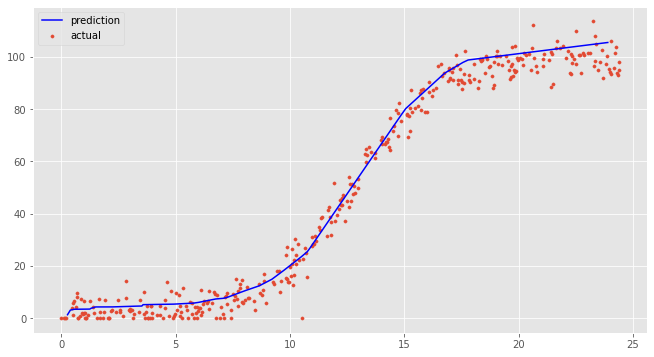

In [41]:
nn_predict = np.sort(nn_predict, axis=0)
A_Test_sort = np.sort(A_Test, axis=0)

plt.scatter(A_Train, B_Train, label='actual', s=10)

# sort_axis_nn = operator.itemgetter(0)
# sorted_zip_nn = sorted(zip(A_Test, nn_predict), key=sort_axis)
# sorted_poly_x_nn, sorted_y_test_predict_nn = zip(*sorted_zip)

plt.plot(A_Test_sort, nn_predict, label='prediction', color='b')
plt.legend()

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [43]:
# model.save('my_model.h5')

In [44]:
model.predict([14])

array([[66.69615]], dtype=float32)

In [45]:
r3_test = r2_score(A_Test, nn_predict)
mse3_test = mean_squared_error(A_Test, nn_predict)

In [46]:
r3_test, mse3_test

(-73.36992739173965, 3688.892714419115)

In [61]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_clean2.values
# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]
# define base model
def baseline_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
#     model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)


Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 4551.1157
Epoch 2/300
44/44 [==============================] - 0s 2ms/step - loss: 4402.1000
Epoch 3/300
44/44 [==============================] - 0s 3ms/step - loss: 4019.8056
Epoch 4/300
44/44 [==============================] - 0s 2ms/step - loss: 4264.4862
Epoch 5/300
44/44 [==============================] - 0s 3ms/step - loss: 3666.3400
Epoch 6/300
44/44 [==============================] - 0s 3ms/step - loss: 3175.0308
Epoch 7/300
44/44 [==============================] - 0s 2ms/step - loss: 3241.7652
Epoch 8/300
44/44 [==============================] - 0s 3ms/step - loss: 2784.7479
Epoch 9/300
44/44 [==============================] - 0s 2ms/step - loss: 2521.0222
Epoch 10/300
44/44 [==============================] - 0s 3ms/step - loss: 2208.8093
Epoch 11/300
44/44 [==============================] - 0s 3ms/step - loss: 2154.2512
Epoch 12/300
44/44 [==============================] - 0s 3ms/step - loss: 1998.9741
E

44/44 [==============================] - 0s 2ms/step - loss: 31.5269
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 26.7712
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 30.1914
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 31.4095
Epoch 104/300
44/44 [==============================] - 0s 2ms/step - loss: 29.5481
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 31.2851
Epoch 106/300
44/44 [==============================] - 0s 3ms/step - loss: 28.1126
Epoch 107/300
44/44 [==============================] - 0s 3ms/step - loss: 29.0726
Epoch 108/300
44/44 [==============================] - 0s 2ms/step - loss: 28.4876
Epoch 109/300
44/44 [==============================] - 0s 3ms/step - loss: 29.7856
Epoch 110/300
44/44 [==============================] - 0s 2ms/step - loss: 30.8610
Epoch 111/300
44/44 [==============================] - 0s 2ms/step - loss: 31.2919
Epoch 112/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.4877
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1314
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3535
Epoch 201/300
44/44 [==============================] - 0s 3ms/step - loss: 19.1427
Epoch 202/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2032
Epoch 203/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1570
Epoch 204/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9379
Epoch 205/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2422
Epoch 206/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6705
Epoch 207/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9937
Epoch 208/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7104
Epoch 209/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2884
Epoch 210/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.3588
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1148
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2668
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3495
Epoch 300/300
5/5 [==============================] - 0s 5ms/step - loss: 10.4577
Epoch 1/300
44/44 [==============================] - 1s 3ms/step - loss: 4506.9985
Epoch 2/300
44/44 [==============================] - 0s 3ms/step - loss: 4160.0929
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 3727.7007
Epoch 4/300
44/44 [==============================] - 0s 2ms/step - loss: 3962.8071
Epoch 5/300
44/44 [==============================] - 0s 2ms/step - loss: 3608.0809
Epoch 6/300
44/44 [==============================] - 0s 2ms/step - loss: 3254.0758
Epoch 7/300
44/44 [==============================] - 0s 2ms/step - loss: 3057.9519
Epoch 8/300
44/44 [=

44/44 [==============================] - 0s 2ms/step - loss: 40.9236
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 37.8907
Epoch 96/300
44/44 [==============================] - 0s 3ms/step - loss: 41.6212
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 37.7682
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 34.9561
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 35.3855
Epoch 100/300
44/44 [==============================] - 0s 2ms/step - loss: 33.6922
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 29.9604
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 32.4063
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 34.2473
Epoch 104/300
44/44 [==============================] - 0s 2ms/step - loss: 31.3264
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 35.4671
Epoch 106/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 19.4825
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7738
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5429
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4762
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1935
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5538
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7163
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8632
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3806
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9829
Epoch 202/300
44/44 [==============================] - 0s 3ms/step - loss: 16.7493
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6192
Epoch 204/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 15.4864
Epoch 291/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1183
Epoch 292/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5516
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9292
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6319
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0939
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0864
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2342
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0551
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8886
Epoch 300/300
5/5 [==============================] - 0s 0s/step - loss: 15.1705
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 4624.4695
Epoch 2/300
44/44 [==

44/44 [==============================] - 0s 3ms/step - loss: 49.9650
Epoch 89/300
44/44 [==============================] - 0s 3ms/step - loss: 45.9464
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 47.9707
Epoch 91/300
44/44 [==============================] - 0s 3ms/step - loss: 42.7936
Epoch 92/300
44/44 [==============================] - 0s 3ms/step - loss: 44.5140
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 40.5219
Epoch 94/300
44/44 [==============================] - 0s 3ms/step - loss: 41.6409
Epoch 95/300
44/44 [==============================] - 0s 3ms/step - loss: 41.5227
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 40.8545
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 46.2356
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 37.7642
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 38.2534
Epoch 100/300
44/44 [========

44/44 [==============================] - 0s 2ms/step - loss: 16.8989
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0985
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9376
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 21.2507
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2209
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2157
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5652
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9894
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0131
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9265
Epoch 197/300
44/44 [==============================] - 0s 3ms/step - loss: 18.6211
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 20.9102
Epoch 199/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.4176
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7598
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7596
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4344
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8354
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5778
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6666
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7712
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0818
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1857
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7804
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9778
Epoch 297/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 47.8677
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 44.6220
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 43.5670
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 38.8980
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 45.5576
Epoch 88/300
44/44 [==============================] - 0s 3ms/step - loss: 41.7568
Epoch 89/300
44/44 [==============================] - 0s 3ms/step - loss: 37.7651
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 43.2021
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 39.4746
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 41.1243
Epoch 93/300
44/44 [==============================] - 0s 3ms/step - loss: 44.1864
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 37.8734
Epoch 95/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 19.4691
Epoch 183/300
44/44 [==============================] - 0s 2ms/step - loss: 22.8649
Epoch 184/300
44/44 [==============================] - 0s 3ms/step - loss: 17.9825
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7413
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 22.0104
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 20.4091
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 22.2466
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4460
Epoch 190/300
44/44 [==============================] - 0s 3ms/step - loss: 18.3886
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6628
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 21.7176
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 20.8536
Epoch 194/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.1045
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0045
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1265
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4914
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7814
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3924
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5774
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6179
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2382
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9787
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5053
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4010
Epoch 292/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 57.3315
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 52.3915
Epoch 80/300
44/44 [==============================] - 0s 3ms/step - loss: 50.3176
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 51.7308
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 49.9452
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 51.5457
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 52.5430
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 48.9732
Epoch 86/300
44/44 [==============================] - 0s 3ms/step - loss: 51.3665
Epoch 87/300
44/44 [==============================] - 0s 3ms/step - loss: 48.6878
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 45.3179
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 46.6911
Epoch 90/300
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 17.3609
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3907
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7273
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2704
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6504
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9318
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8528
Epoch 183/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1628
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8579
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5497
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4481
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4385
Epoch 188/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 14.7730
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9921
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4525
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1302
Epoch 278/300
44/44 [==============================] - 0s 3ms/step - loss: 16.7182
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4005
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0454
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7798
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8838
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9235
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3987
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5843
Epoch 286/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 68.4404
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 58.4200
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 55.7675
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 63.1437
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 51.8797
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 55.8964
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 54.4732
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 53.2398
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 52.1568
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 49.9348
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 53.5080
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 45.8383
Epoch 84/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 20.4962
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2191
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 20.7432
Epoch 174/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2972
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8318
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6793
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 20.7849
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8489
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8227
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 20.8655
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 20.4993
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0512
Epoch 183/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.5575
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4793
Epoch 271/300
44/44 [==============================] - 0s 3ms/step - loss: 19.7076
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0827
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7957
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2026
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1471
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4729
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6910
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6206
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9338
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0327
Epoch 281/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 59.9210
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 59.6406
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 48.0503
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 53.6587
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 58.2863
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 50.5250
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 53.6762
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 48.4721
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 51.7491
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 52.6899
Epoch 77/300
44/44 [==============================] - ETA: 0s - loss: 55.35 - 0s 2ms/step - loss: 50.9899
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 45.3627
Epoch

44/44 [==============================] - 0s 2ms/step - loss: 24.2464
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 20.9671
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6920
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9499
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8724
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8198
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4453
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7683
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4469
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5407
Epoch 175/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2619
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5845
Epoch 177/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 16.8876
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3855
Epoch 265/300
44/44 [==============================] - 0s 3ms/step - loss: 16.2016
Epoch 266/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4002
Epoch 267/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2131
Epoch 268/300
44/44 [==============================] - 0s 3ms/step - loss: 18.6895
Epoch 269/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9296
Epoch 270/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5590
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5257
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2634
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7900
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5183
Epoch 275/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 89.9488
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 76.1814
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 71.7904
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 73.2016
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 70.4105
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 70.8330
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 66.0907
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 62.0755
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 65.7384
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 61.0512
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 60.6230
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 57.5361
Epoch 73/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 19.8868
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 20.6512
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0559
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0490
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3907
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8976
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6226
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6728
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0685
Epoch 169/300
44/44 [==============================] - 0s 3ms/step - loss: 18.0872
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8679
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 20.4001
Epoch 172/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.2890
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9328
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9534
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8943
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6078
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8098
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8405
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2024
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7801
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6678
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5736
Epoch 269/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8425
Epoch 270/300
44/4

Epoch 56/300
44/44 [==============================] - 0s 2ms/step - loss: 95.0377
Epoch 57/300
44/44 [==============================] - 0s 2ms/step - loss: 85.9994
Epoch 58/300
44/44 [==============================] - 0s 2ms/step - loss: 80.5267
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 76.1651
Epoch 60/300
44/44 [==============================] - 0s 2ms/step - loss: 84.2282
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 78.1876
Epoch 62/300
44/44 [==============================] - 0s 3ms/step - loss: 74.4734
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 64.8663
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 62.4239
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 64.3307
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 59.7078
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 59.2283
Epoch 68/300
44/

Epoch 155/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4318
Epoch 156/300
44/44 [==============================] - 0s 3ms/step - loss: 19.9550
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6503
Epoch 158/300
44/44 [==============================] - 0s 3ms/step - loss: 20.5490
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8222
Epoch 160/300
44/44 [==============================] - 0s 3ms/step - loss: 19.6535
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6980
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1666
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 20.5743
Epoch 164/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0179
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3032
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 21.7485
Epoc

44/44 [==============================] - 0s 2ms/step - loss: 17.3535
Epoch 254/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4635
Epoch 255/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9000
Epoch 256/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4371
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7977
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8278
Epoch 259/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4612
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0410
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6727
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7209
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3085
Epoch 264/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3263
Epoch 265/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 107.7294
Epoch 51/300
44/44 [==============================] - 0s 2ms/step - loss: 115.8820
Epoch 52/300
44/44 [==============================] - 0s 2ms/step - loss: 108.1066
Epoch 53/300
44/44 [==============================] - 0s 2ms/step - loss: 103.4951
Epoch 54/300
44/44 [==============================] - 0s 2ms/step - loss: 98.4706
Epoch 55/300
44/44 [==============================] - 0s 2ms/step - loss: 90.9127
Epoch 56/300
44/44 [==============================] - 0s 2ms/step - loss: 97.6725
Epoch 57/300
44/44 [==============================] - 0s 2ms/step - loss: 86.8282
Epoch 58/300
44/44 [==============================] - 0s 2ms/step - loss: 77.3303
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 70.0444
Epoch 60/300
44/44 [==============================] - 0s 2ms/step - loss: 67.9182
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 68.6049
Epoch 62/300
44/44 [=====

44/44 [==============================] - 0s 2ms/step - loss: 20.3193
Epoch 150/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7832
Epoch 151/300
44/44 [==============================] - 0s 2ms/step - loss: 22.7501
Epoch 152/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5292
Epoch 153/300
44/44 [==============================] - 0s 2ms/step - loss: 20.0420
Epoch 154/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0894
Epoch 155/300
44/44 [==============================] - 0s 2ms/step - loss: 20.3488
Epoch 156/300
44/44 [==============================] - 0s 3ms/step - loss: 19.4679
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3354
Epoch 158/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2431
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0937
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0271
Epoch 161/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.0143
Epoch 248/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8571
Epoch 249/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9741
Epoch 250/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4957
Epoch 251/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4221
Epoch 252/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5875
Epoch 253/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3308
Epoch 254/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4292
Epoch 255/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4903
Epoch 256/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1135
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8723
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6205
Epoch 259/300
44/4

In [58]:
# 1 layer, sigmoid, 200 epochs, lr=0.01
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std())) 

Standardized: -17.18 (4.99) MSE


In [56]:
# 1 layer, sigmoid, 100 epochs, lr=0.01
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -18.90 (7.09) MSE


In [50]:
# 2 layers, relu and relu, 500, lr=0.001
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -21.81 (8.18) MSE


In [60]:
# 1 layer, sigmoid, 300 epochs, lr=0.01
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -17.63 (5.55) MSE


In [62]:
# 1 layer, sigmoid, 300 epochs, lr=0.001
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -17.41 (4.61) MSE


In [51]:
len(X)

486

In [52]:
ep_100 = 25
ep_500_10 = 23.87

In [ ]:
np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 20)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

### References

[1] w3schools.com; Numpy Introduction; https://www.w3schools.com/python/numpy_intro.asp <br>
[2] w3schools.com; Pandas Tutorial https://www.w3schools.com/python/pandas_tutorial.asp <br>
[3] w3schools.com; Matplotlib Pyplot; https://www.w3schools.com/python/matplotlib_pyplot.asp <br>
[4] wikipedia.org; scikit_learn https://en.wikipedia.org/wiki/Scikit-learn <br>
[5] tensorflow.org; https://www.tensorflow.org/ <br>
[6] keras.io; https://keras.io/ <br>
[7] youtube.com; Wind Turbine Power Curve description; https://www.youtube.com/watch?v=8tNOL4ZL9Do <br>
[8] Brownlee, J.; Difference Between Classification and Regression in Machine Learning https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ <br>
[9] *Ibid* <br>
[10] Wikipedia.org; Regression analysis; https://en.wikipedia.org/wiki/Regression_analysis <br>
[11] yale.edu; Linear Regression; http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm <br>
[12] wikipdeia.org; scikit-learn; https://en.wikipedia.org/wiki/Scikit-learn <br>
[13] realpython.com; Split Your Dataset With scikit-learn's train_test_split(); https://realpython.com/train-test-split-python-data/ <br>
[14] machinelearningmastery.com; Train-Test Split for Evaluating Machine Learning Algorithms; https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ <br>
[15] *Ibid* <br>
[16] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[17] Pei, S. and Li, P., 2019; Wind Turbine Power Curve Modeling with a Hybrid Machine Learning Technique; https://www.researchgate.net/publication/337325612_Wind_Turbine_Power_Curve_Modeling_with_a_Hybrid_Machine_Learning_Technique <br>
[18] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[19] Brownlee, J; How to Remove Outliers for Machine Learning; https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[20] *Ibid* <br>
[21] Frost, J; 5 Ways to Find Outliers in Your Data; https://statisticsbyjim.com/basics/outliers/ <br>
[22] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[23] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[24] Frost, J; How To Interpret R-squared in Regression Analysis; https://statisticsbyjim.com/regression/interpret-r-squared-regression/ <br>
[25] *Ibid* <br>
[26] Agarwal, A.; Polynomial Regression; https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 <br>
[27] *Ibid* <br>
[28] *Ibid* <br>